# Hack The Feed: Insights From Social Media Data

### 🎯 Project Brief

Playhouse Communication is one of Nigeria's leading digital marketing agencies. They combine design and media planning with cutting-edge tech solutions to reimagine what marketing is all about. Their client roster is a mix of global juggernauts and nimble SMEs, each redefining their sectors.

We are rolling out the ultimate arena for innovation in data and setting the stage for up and coming data scientists and analysts to showcase their skills, win huge cash prizes, and boost their careers. The "Hack the Feed" hackathon is a showdown where data analytics meets creative prowess.

Your mission? To decode a treasure trove of social media data for one of our high-profile clients and transform it into game-changing insights.

In a rare move, we're handing you the keys to a vault of exclusive social media data to let you dig deep, get creative, and strike gold with actionable insights that could redefine the future of digital marketing.  This isn't just a hackathon; it's your chance to shape the future of digital engagement. 🚀

Key Deliverables:
Participants are expected to:

    Create a comprehensive and reproducible report detailing their findings.
    Propose actionable recommendations based on the insights.
    Create a simple and engaging visualisation of your results & analysis.


Evaluation Criteria:
Submissions will be evaluated based on the following:

    Innovativeness:
        Originality and novelty of the insights.
    Actionability:
        Practicality and feasibility of the recommendations.
    Presentation Quality:
        Clarity and effectiveness in conveying findings in writing and visual form.
    Depth of Analysis:
        How thoroughly the data has been explored and understood.

In [1]:
import os
import gc
import shutil
import copy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

import seaborn as sns
import plotly.express as px
import random
from collections import defaultdict
from typing import Union, List, Literal, Dict, Callable, Tuple, Optional
from tqdm import tqdm
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold, KFold

In [2]:
import nltk
from IPython.display import display
from nltk.tokenize import sent_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from collections import Counter
nltk.download('stopwords')
nltk.download('vader_lexicon')

import string
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [3]:
data_dir = '/content/drive/MyDrive/Hack The Feed Hackathon'
os.chdir(data_dir)

In [4]:
fb_data = pd.read_csv('Post Performance (Stanbic IBTC) January 1, 2013 - July 13, 2023_Facebook.csv', low_memory=False)
x_data = pd.read_csv('Post Performance (Stanbic IBTC) January 1, 2013 - July 13, 2023_Twitter.csv', low_memory=False)
ig_data = pd.read_csv('Post Performance (Stanbic IBTC) January 1, 2013 - July 13, 2023_Instagram.csv', low_memory=False)
ld_data = pd.read_csv('Post Performance (Stanbic IBTC) January 1, 2013 - July 13, 2023_LinkedIn.csv', low_memory=False)

## IG_Data

In [5]:
ig_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 147 entries, Date to Tags
dtypes: float64(125), int64(1), object(21)
memory usage: 11.2+ MB


In [6]:
ig_cols = ig_data.columns

cols_missing = ig_data[ig_cols].isnull().sum().to_dict()
for col in cols_missing:
  if cols_missing[col] > 0.5 * ig_data.shape[0]:
    print(col,"=====|=====",cols_missing[col])
    ig_cols=ig_cols.drop(col)

Linked Content =====|===== 10000
Viral Impressions =====|===== 10000
Non-viral Impressions =====|===== 10000
Paid Impressions =====|===== 10000
Fan Impressions =====|===== 10000
Fan Organic Impressions =====|===== 10000
Fan Paid Impressions =====|===== 10000
Non-fan Impressions =====|===== 10000
Non-fan Organic Impressions =====|===== 10000
Non-fan Paid Impressions =====|===== 10000
Viral Reach =====|===== 10000
Non-viral Reach =====|===== 10000
Paid Reach =====|===== 10000
Fan Reach =====|===== 10000
Fan Paid Reach =====|===== 10000
Potential Reach =====|===== 10000
Dislikes =====|===== 10000
Love Reactions =====|===== 10000
Haha Reactions =====|===== 10000
Wow Reactions =====|===== 10000
Sad Reactions =====|===== 10000
Angry Reactions =====|===== 10000
Shares =====|===== 10000
Click-Through Rate =====|===== 10000
Post Link Clicks =====|===== 10000
Other Post Clicks =====|===== 10000
Post Clicks (All) =====|===== 10000
Post Media Clicks =====|===== 10000
Post Hashtag Clicks =====|====

In [7]:
cleaned_data = ig_data[ig_cols]

In [8]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Date                              10000 non-null  object 
 1   Post ID                           10000 non-null  int64  
 2   Network                           10000 non-null  object 
 3   Post Type                         10000 non-null  object 
 4   Content Type                      10000 non-null  object 
 5   Profile                           10000 non-null  object 
 6   Sent by                           10000 non-null  object 
 7   Link                              10000 non-null  object 
 8   Post                              9989 non-null   object 
 9   Impressions                       8516 non-null   object 
 10  Organic Impressions               8516 non-null   object 
 11  Reach                             8516 non-null   object 
 12  Organ

In [9]:
low_cardinality_columns = []
high_cardinality_columns = []
medium_cardinality_columns = []
cat_cols = cleaned_data.select_dtypes(include=['object']).columns

for col in cat_cols:
  num_uniq = cleaned_data[col].nunique()
  if num_uniq < 5:
    low_cardinality_columns.append(col)
  elif num_uniq > 20:
    high_cardinality_columns.append(col)
  else:
    medium_cardinality_columns.append(col)

In [10]:
cleaned_data[low_cardinality_columns].head(3)

,Network,Post Type,Content Type,Profile
0,Instagram,Post,Carousel,stanbicibtc
1,Instagram,Post,Photo,stanbicibtc
2,Instagram,Post,Video,stanbicibtc


### High Cardinality Columns

In [11]:
cleaned_data[high_cardinality_columns[:5]].head(5)

,Date,Link,Post,Impressions,Organic Impressions
0,1/30/2023 5:06 pm,https://www.instagram.com/p/CoC6CKBIHbV/,The new Naira banknotes in circulation have se...,"39,681","39,681"
1,4/15/2022 9:04 am,https://www.instagram.com/p/CcXUQTEMRm7/,We hope the faith that this #GoodFriday restor...,"29,186","29,186"
2,5/28/2021 8:45 pm,https://www.instagram.com/p/CPbcdjygiaK/,Reposted from @mzdosunmu My son's entry\n#ITCA...,"21,175","21,175"
3,1/4/2023 4:08 pm,https://www.instagram.com/p/Cm_2oino-Me/,The new Naira banknotes in circulation have se...,"23,425","23,425"
4,12/7/2021 6:52 pm,https://www.instagram.com/p/CXMNAKFsjSs/,"If you were born in June, ‘cut soap for us oh’...","21,033","21,033"


In [12]:
impression_cols = high_cardinality_columns[3:5]
reach_cols = high_cardinality_columns[5:7]
cleaned_data[impression_cols].head(5)

,Impressions,Organic Impressions
0,"39,681","39,681"
1,"29,186","29,186"
2,"21,175","21,175"
3,"23,425","23,425"
4,"21,033","21,033"


In [13]:
cleaned_data[impression_cols].isnull().sum()

Impressions            1484
Organic Impressions    1484
dtype: int64

In [14]:
cleaned_data[reach_cols].isnull().sum()

Reach            1484
Organic Reach    1484
dtype: int64

In [15]:
cleaned_impressions_reach = cleaned_data

for col in cleaned_impressions_reach[impression_cols].columns:
  cleaned_impressions_reach = cleaned_impressions_reach[cleaned_impressions_reach[col].notna()].reset_index(drop=True)

In [16]:
cleaned_impressions_reach[impression_cols] = cleaned_impressions_reach[impression_cols].apply(
    lambda row:row.str.replace(',','').astype("int"), axis=1)

cleaned_impressions_reach[reach_cols] = cleaned_impressions_reach[reach_cols].apply(
    lambda row:row.str.replace(',','').astype("int"), axis=1)

In [17]:
def get_time_period(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

def get_quarter(month):
    if 1 <= month <= 3:
        return 'Q1'
    elif 4 <= month <= 6:
        return 'Q2'
    elif 7 <= month <= 9:
        return 'Q3'
    else:
        return 'Q4'

def get_season(month):
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Autumn'
    else:
        return 'Winter'

def get_day_period(day_of_week):
    if 0 <= day_of_week <= 4:  # Monday to Friday
        return 'Weekday'
    else:  # Saturday and Sunday
        return 'Weekend'

In [18]:
holidays = pd.read_excel('NigerianHolidays.xlsx')
holidays['month-day'] = pd.to_datetime(holidays.Date).dt.strftime('%m-%d')

In [19]:
holidays = holidays.set_index('month-day')
holiday_names = holidays['Name'].to_dict()
holiday_types = holidays['Type'].to_dict()

In [20]:
cleaned_impressions_reach['year'] = pd.to_datetime(cleaned_impressions_reach.Date).dt.year
cleaned_impressions_reach['month_name'] = pd.to_datetime(cleaned_impressions_reach.Date).dt.month_name()
cleaned_impressions_reach['month'] = pd.to_datetime(cleaned_impressions_reach.Date).dt.month
cleaned_impressions_reach['day_name'] = pd.to_datetime(cleaned_impressions_reach.Date).dt.day_name()
cleaned_impressions_reach['day'] = pd.to_datetime(cleaned_impressions_reach.Date).dt.day
cleaned_impressions_reach['hour'] = pd.to_datetime(cleaned_impressions_reach.Date).dt.hour
cleaned_impressions_reach['minute'] = pd.to_datetime(cleaned_impressions_reach.Date).dt.minute
cleaned_impressions_reach['day_of_week'] = pd.to_datetime(cleaned_impressions_reach.Date).dt.dayofweek
cleaned_impressions_reach['month-day'] = pd.to_datetime(cleaned_impressions_reach.Date).dt.strftime('%m-%d')

In [21]:
cleaned_impressions_reach['time_period'] = cleaned_impressions_reach['hour'].apply(get_time_period)
cleaned_impressions_reach['quarter'] = cleaned_impressions_reach['month'].apply(get_quarter)
cleaned_impressions_reach['season'] = cleaned_impressions_reach['month'].apply(get_season)
cleaned_impressions_reach['day_period'] = cleaned_impressions_reach['day_of_week'].apply(get_day_period)
cleaned_impressions_reach['holiday_names'] = cleaned_impressions_reach['month-day'].map(holiday_names).fillna("Regular Day")
cleaned_impressions_reach['holiday_types'] = cleaned_impressions_reach['month-day'].map(holiday_types).fillna("Regular Type")

In [22]:
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday', 'Sunday']
cleaned_impressions_reach['day_name'] = pd.Categorical(cleaned_impressions_reach['day_name'], categories=order, ordered=True)



order = ['Morning', 'Afternoon', 'Evening', 'Night']
cleaned_impressions_reach['time_period'] = pd.Categorical(cleaned_impressions_reach['time_period'], categories=order, ordered=True)

In [23]:
plot_cols = ['year','time_period','day_name','day_period','quarter','holiday_types']

fig = make_subplots(rows=2, cols=3, subplot_titles=plot_cols)
for i, col in enumerate(plot_cols):
  nrow = i // 3
  ncol = i % 3

  df = cleaned_impressions_reach[cleaned_impressions_reach[col]!='Regular Type']
  df_yearly = df.groupby(col)[['Post']].count()
  fig.add_trace(
      go.Scatter(x=df_yearly.index, y=df_yearly.values.flatten(),
                    mode='lines+markers',name=col),
      row=nrow+1,col=ncol+1
  )
  fig.update_xaxes(title_text=col, row=nrow+1,col=ncol+1)
  fig.update_yaxes(title_text="Count", row=nrow+1,col=ncol+1)


fig.update_layout(height=800, width=1200,legend_title='Categories', autosize=False,
                  title_text="Trend of Posts")


fig.show()


In [24]:
cleaned_impressions_reach[impression_cols+reach_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Impressions,8516.0,2273.855214,1742.647997,0.0,1359.75,1997.5,2780.25,39681.0
Organic Impressions,8516.0,2273.855214,1742.647997,0.0,1359.75,1997.5,2780.25,39681.0
Reach,8516.0,1503.111790,1769.934182,0.0,2.00,1271.0,2240.00,32418.0
Organic Reach,8516.0,1503.111790,1769.934182,0.0,2.00,1271.0,2240.00,32418.0


In [25]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
ss = StandardScaler()
mm = MinMaxScaler()

In [26]:
# def plot_bars(df, plot_cols, cols, scale=True, barWidth=0.25, length=20, width=15):
#   top_df = df.copy()
#   if scale:
#     top_df.loc[:, cols] = mm.fit_transform(df[cols])

#   fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(length, width))
#   axs = axs.ravel()
#   colors = ['red','green','blue','yellow','skyblue', 'olive', 'gold', 'purple', 'orange', 'brown']

#   for i, column in enumerate(plot_cols):
#     df = top_df.groupby([column])[cols].sum()
#     barWidth = barWidth
#     r = [np.arange(len(df)) + i*barWidth for i in range(len(cols))]
#     for j, col in enumerate(cols):
#         axs[i].bar(r[j], df[col], color=colors[j], width=barWidth, edgecolor='grey', label=col)

#     axs[i].set_xlabel(column, fontweight='bold')
#     axs[i].set_xticks([r + barWidth for r in range(len(df))], df.index)
#     axs[i].legend()

#   plt.show()



In [27]:
def plot_bars(df, plot_cols, cols, scale=True, barWidth=0.25, height=800, width=1500):
  top_df = df.copy()
  if scale:
    top_df.loc[:, cols] = mm.fit_transform(df[cols])

  fig = make_subplots(rows=2, cols=3)
  colors = ['red','green','blue','yellow','skyblue', 'olive', 'gold', 'purple', 'orange', 'brown']

  for i, column in enumerate(plot_cols):
    nrow = i // 3
    ncol = i % 3

    df = top_df.groupby([column])[cols].sum()
    r = [np.arange(len(df)) + i*barWidth for i in range(len(cols))]

    for j, col in enumerate(cols):
      showlegend = True if i == 0 else False
      fig.add_trace(
          go.Bar(x=r[j], y=df[col], marker_color=colors[j], width=barWidth, showlegend=showlegend, name=col),
          row=nrow+1,col=ncol+1
        )
      fig.update_xaxes(title_text=column,
                       title_font=dict(size=14, color='black', family='Courier New, monospace'),
                       tickvals=[r + barWidth for r in range(len(df))],
                       ticktext = df.index,
                       row=nrow+1,col=ncol+1)
      fig.update_yaxes(title_text="Count", row=nrow+1,col=ncol+1)

  fig.update_layout(height=height, width=width,legend_title='Categories',
                      title_text="Trend of Posts",barmode='group')


  fig.show()



In [28]:
# def plot_bars_quantile(df, plot_cols, cols, quantile=0.99, scale=True, barWidth=0.25, length=20, width=15):
#   last_quantile = df[cols[-1]].quantile(quantile)
#   top_df = df[df[cols[-1]] > last_quantile].copy()
#   if scale:
#     top_df.loc[:, cols] = mm.fit_transform(top_df[cols])

#   fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(length, width))
#   axs = axs.ravel()
#   colors = ['red','green','blue','yellow','skyblue', 'olive', 'gold', 'purple', 'orange', 'brown']

#   for i, column in enumerate(plot_cols):
#     df = top_df.groupby([column])[cols].sum().sort_values(by=[cols[-1]], ascending=False)
#     barWidth = barWidth
#     r = [np.arange(len(df)) + i*barWidth for i in range(len(cols))]
#     for j, col in enumerate(cols):
#         axs[i].bar(r[j], df[col], color=colors[j], width=barWidth, edgecolor='grey', label=col)

#     axs[i].set_xlabel(column, fontweight='bold')
#     axs[i].set_xticks([r + barWidth for r in range(len(df))], df.index)
#     axs[i].legend()

#   plt.show()



In [29]:
def plot_bars_quantile(df, plot_cols, cols, quantile=0.99, scale=True, barWidth=0.25, height=800, width=1500):
  last_quantile = df[cols[-1]].quantile(quantile)
  top_df = df[df[cols[-1]] > last_quantile].copy()
  if scale:
    top_df.loc[:, cols] = mm.fit_transform(top_df[cols])

  fig = make_subplots(rows=2, cols=3)
  colors = ['red','green','blue','yellow','skyblue', 'olive', 'gold', 'purple', 'orange', 'brown']

  for i, column in enumerate(plot_cols):
    nrow = i // 3
    ncol = i % 3

    df = top_df.groupby([column])[cols].sum().sort_values(by=[cols[-1]], ascending=False)
    barWidth = barWidth
    r = [np.arange(len(df)) + i*barWidth for i in range(len(cols))]

    for j, col in enumerate(cols):
      showlegend = True if i == 0 else False
      fig.add_trace(
          go.Bar(x=r[j], y=df[col], marker_color=colors[j], width=barWidth, showlegend=showlegend, name=col),
          row=nrow+1,col=ncol+1
        )
      fig.update_xaxes(title_text=column,
                       title_font=dict(size=14, color='black', family='Courier New, monospace'),
                       tickvals=[r + barWidth for r in range(len(df))],
                       ticktext = df.index,
                       row=nrow+1,col=ncol+1)
      fig.update_yaxes(title_text="Count", row=nrow+1,col=ncol+1)

  fig.update_layout(height=height, width=width,legend_title='Categories',
                      title_text="Trend of Posts",barmode='group')


  fig.show()

In [30]:
# Call the function
plot_cols = ['year','time_period','day_name','day_period','quarter','holiday_types']
plot_bars_quantile(cleaned_impressions_reach, plot_cols, impression_cols[::-1], quantile=0.99, scale=False)

In [31]:
plot_bars_quantile(cleaned_impressions_reach, plot_cols, reach_cols[::-1], quantile=0.99, scale=False)

In [32]:
cleaned_impressions_reach['Engagements'] = cleaned_impressions_reach['Engagements'].str.replace(',','').astype("int")

In [33]:
cleaned_impressions_reach['Engagement Rate (per Impression)'] = (cleaned_impressions_reach['Engagements'] / cleaned_impressions_reach['Impressions']) * 100
cleaned_impressions_reach['Engagement Rate (per Reach)'] = (cleaned_impressions_reach['Engagements'] / cleaned_impressions_reach['Reach']) * 100

In [34]:
engagement_cols = high_cardinality_columns[7:10]

In [35]:
cleaned_impressions_reach[engagement_cols] = cleaned_impressions_reach[engagement_cols].replace([np.inf, -np.inf, np.nan], 0)

In [36]:
cleaned_impressions_reach[engagement_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Engagement Rate (per Impression),8516.0,37.886214,432.982527,0.0,2.274654,2.977099,3.919937,14200.0
Engagement Rate (per Reach),8516.0,1227.884184,3437.678809,0.0,2.071642,2.950311,4.742653,65600.0
Engagements,8516.0,112.031353,857.103273,0.0,38.000000,62.000000,96.000000,33395.0


In [37]:
plot_bars_quantile(cleaned_impressions_reach, plot_cols, engagement_cols, quantile=0.99, scale=False)

In [38]:
rlc_cols = high_cardinality_columns[10:]
cleaned_impressions_reach[rlc_cols].head()

,Reactions,Likes,Comments
0,"1,261","1,261",56
1,709,709,"1,033"
2,702,702,23
3,677,677,36
4,757,757,606


In [39]:
cleaned_impressions_reach[rlc_cols] = cleaned_impressions_reach[rlc_cols].apply(
    lambda row:row.str.replace(',','').astype("int"), axis=1)

In [40]:
cleaned_impressions_reach[rlc_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Reactions,8516.0,101.083138,855.851720,0.0,32.0,55.0,85.0,33394.0
Likes,8516.0,101.083138,855.851720,0.0,32.0,55.0,85.0,33394.0
Comments,8516.0,8.898779,25.553781,0.0,1.0,3.0,9.0,1033.0


In [41]:
plot_bars_quantile(cleaned_impressions_reach, plot_cols, rlc_cols[::-1], quantile=0.99, scale=False)

In [42]:
plot_bars_quantile(cleaned_impressions_reach, plot_cols, rlc_cols, quantile=0.99, scale=False)

### Whole Dataset

In [43]:
plot_bars(cleaned_impressions_reach, plot_cols, impression_cols)

In [44]:
plot_bars(cleaned_impressions_reach, plot_cols, reach_cols)

In [45]:
plot_bars(cleaned_impressions_reach, plot_cols, engagement_cols)

In [46]:
plot_bars(cleaned_impressions_reach, plot_cols, rlc_cols)

In [47]:
def heatmap(df, length=10, width=5, cmap='rocket'):
  heatmap_df = df.corr(numeric_only=True)
  fig, ax = plt.subplots(figsize=(length, width))
  sns.heatmap(data=heatmap_df, annot=True, cmap=cmap, ax=ax)
  # ax.set_title(f'Heatmap of {" and ".join(list(df.columns))}')
  plt.show()

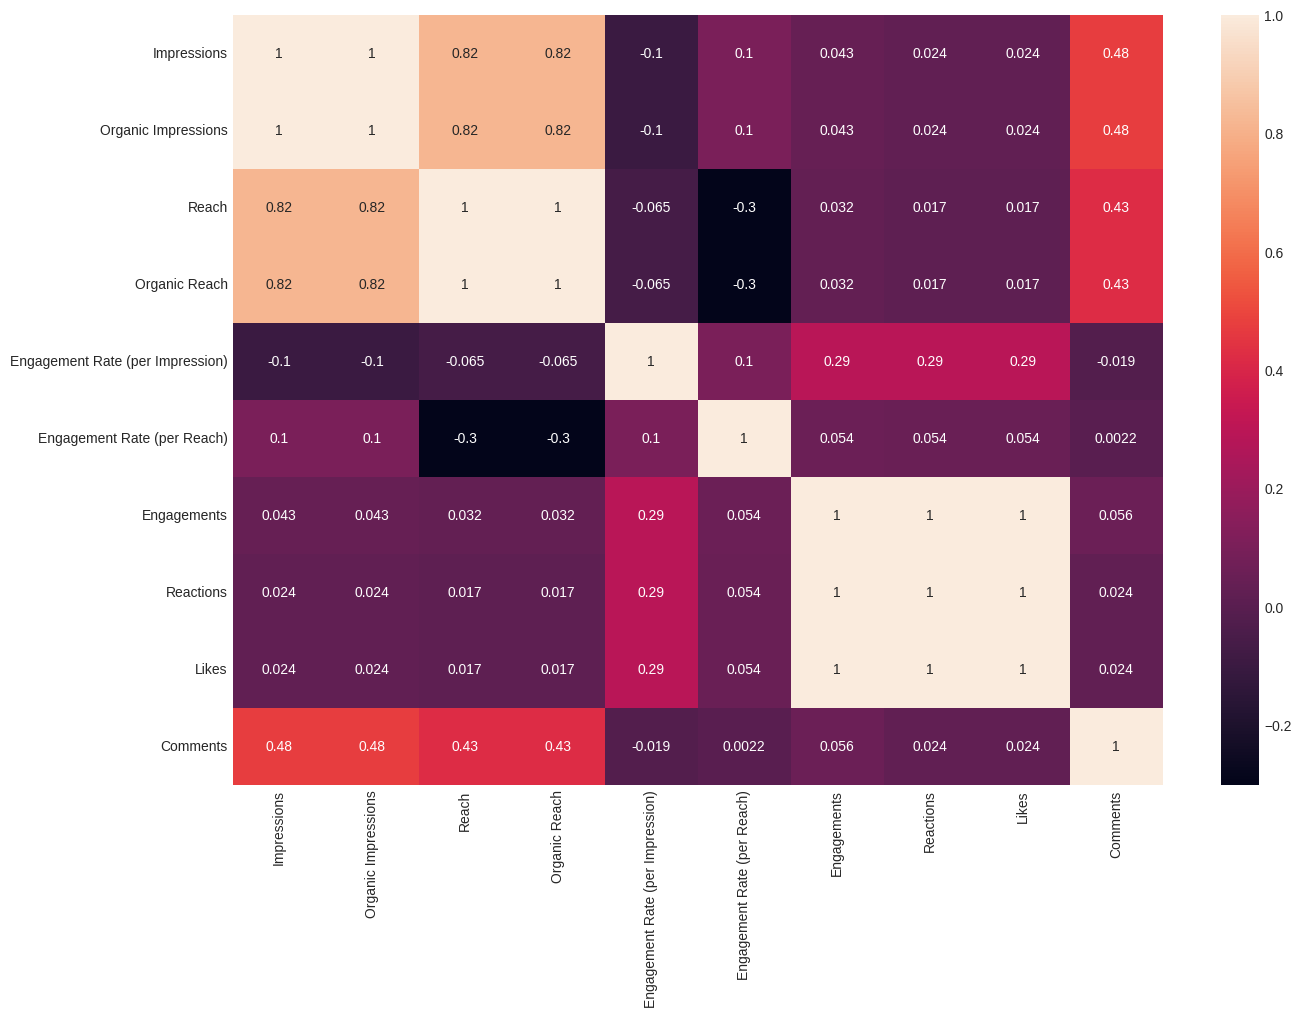

In [48]:
corr_matrix = cleaned_impressions_reach[high_cardinality_columns[3:]]
heatmap(corr_matrix, length=15, width=10)

In [49]:
# def time_series_analysis(df, metrics, duration, fill=False, length=15, width=10):
#   df = df.copy()
#   df['Date'] = pd.to_datetime(df['Date'])
#   df.set_index('Date', inplace=True)

#   fig, ax = plt.subplots(figsize=(length,width),dpi=120)

#   for metric in metrics:
#     duration_mean = df[metric].resample(duration).mean()
#     duration_mean.plot(ax=ax, label=metric)
#     if fill:
#       ax.fill_between(duration_mean.index, y1=duration_mean.values, y2=-duration_mean.values, alpha=0.5, linewidth=2, color='seagreen')


#   ax.set_xlabel('Time')
#   ax.set_ylabel('Value')
#   ax.set_title('Trend Analysis')

#   ax.legend()
#   if fill:
#     ax.hlines(y=0, xmin=np.min(df.index), xmax=np.max(df.index), linewidth=.5)

#   plt.show()

In [50]:
def time_series_analysis(df, metrics, duration, fill=False, height=600, width=1200):
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    fig = go.Figure()

    for metric in metrics:
        duration_mean = df[metric].resample(duration).mean()
        fig.add_trace(go.Scatter(x=duration_mean.index, y=duration_mean.values, mode='lines', name=metric))
        if fill:
            fig.add_trace(go.Scatter(x=duration_mean.index, y=-duration_mean.values, mode='lines', name=metric, showlegend=False,
                                     fill='tonexty'))

    fig.update_layout(height=height, width=width,
                      title_text='Trend Analysis',
                      xaxis_title='Time',
                      yaxis_title='Value')

    if fill:
      fig.add_shape(
          type="line",
          x0=np.min(df.index),
          y0=0,
          x1=np.max(df.index),
          y1=0,
          line=dict(
              color="LightSeaGreen",
              width=1.0),
          )

    fig.show()


In [ ]:
time_series_analysis(cleaned_impressions_reach,
                     impression_cols,
                     duration='Y')

In [ ]:
time_series_analysis(cleaned_impressions_reach,
                     impression_cols,
                     duration='M', fill=True)

In [ ]:
time_series_analysis(cleaned_impressions_reach,
                     impression_cols,
                     duration='7D', fill=True)

In [ ]:
time_series_analysis(cleaned_impressions_reach,
                     reach_cols,
                     duration='Y')

In [ ]:
time_series_analysis(cleaned_impressions_reach,
                     reach_cols,
                     duration='M', fill=True)

In [ ]:
time_series_analysis(cleaned_impressions_reach,
                     reach_cols,
                     duration='7D', fill=True)

In [57]:
time_series_analysis(cleaned_impressions_reach,
                     ['Engagements'],
                     duration='Y')

In [58]:
time_series_analysis(cleaned_impressions_reach,
                     ['Engagements'],
                     duration='M', fill=True)

In [59]:
time_series_analysis(cleaned_impressions_reach,
                     ['Engagements'],
                     duration='7D', fill=True)

In [60]:
time_series_analysis(cleaned_impressions_reach,
                     rlc_cols,
                     duration='Y')

In [61]:
time_series_analysis(cleaned_impressions_reach,
                     rlc_cols,
                     duration='M', fill=True)

In [62]:
medium_cardinality_columns

['Sent by']

In [63]:
cleaned_impressions_reach['Sent by'] = np.where(
    cleaned_impressions_reach['Sent by']==' ', cleaned_impressions_reach['Sent by'].replace(
        ' ','Unknown'), cleaned_impressions_reach['Sent by'])

In [64]:
df_grouped = cleaned_impressions_reach.groupby('Sent by')[['Post']].count().sort_values(by=['Post'],ascending=False)
df_grouped

,Post
Sent by,
Unknown,3535
Blessing Ubah,2668
Aramide Salami,1717
Kemi Amoo,311
Sophia Amuka,190
Damilare Oyekanmi,86


In [65]:
df_grouped = cleaned_impressions_reach.groupby('Sent by')[engagement_cols].sum().sort_values(by=['Engagements'],ascending=False)
df_grouped

,Engagement Rate (per Impression),Engagement Rate (per Reach),Engagements
Sent by,,,
Unknown,306089.226377,6.769040e+06,602905
Aramide Salami,6504.718924,3.676842e+06,172664
Blessing Ubah,8517.428917,9.106695e+03,147619
Kemi Amoo,805.473187,8.784062e+02,18027
Sophia Amuka,479.944813,5.265483e+02,8771
Damilare Oyekanmi,242.206500,2.682429e+02,4073


### Numerical Columns

In [66]:
num_cols = list(cleaned_data.select_dtypes(include=['float64']).columns)
num_cols

['Saves']

In [67]:
cleaned_impressions_reach[num_cols].head(5)

,Saves
0,625.0
1,21.0
2,11.0
3,337.0
4,20.0


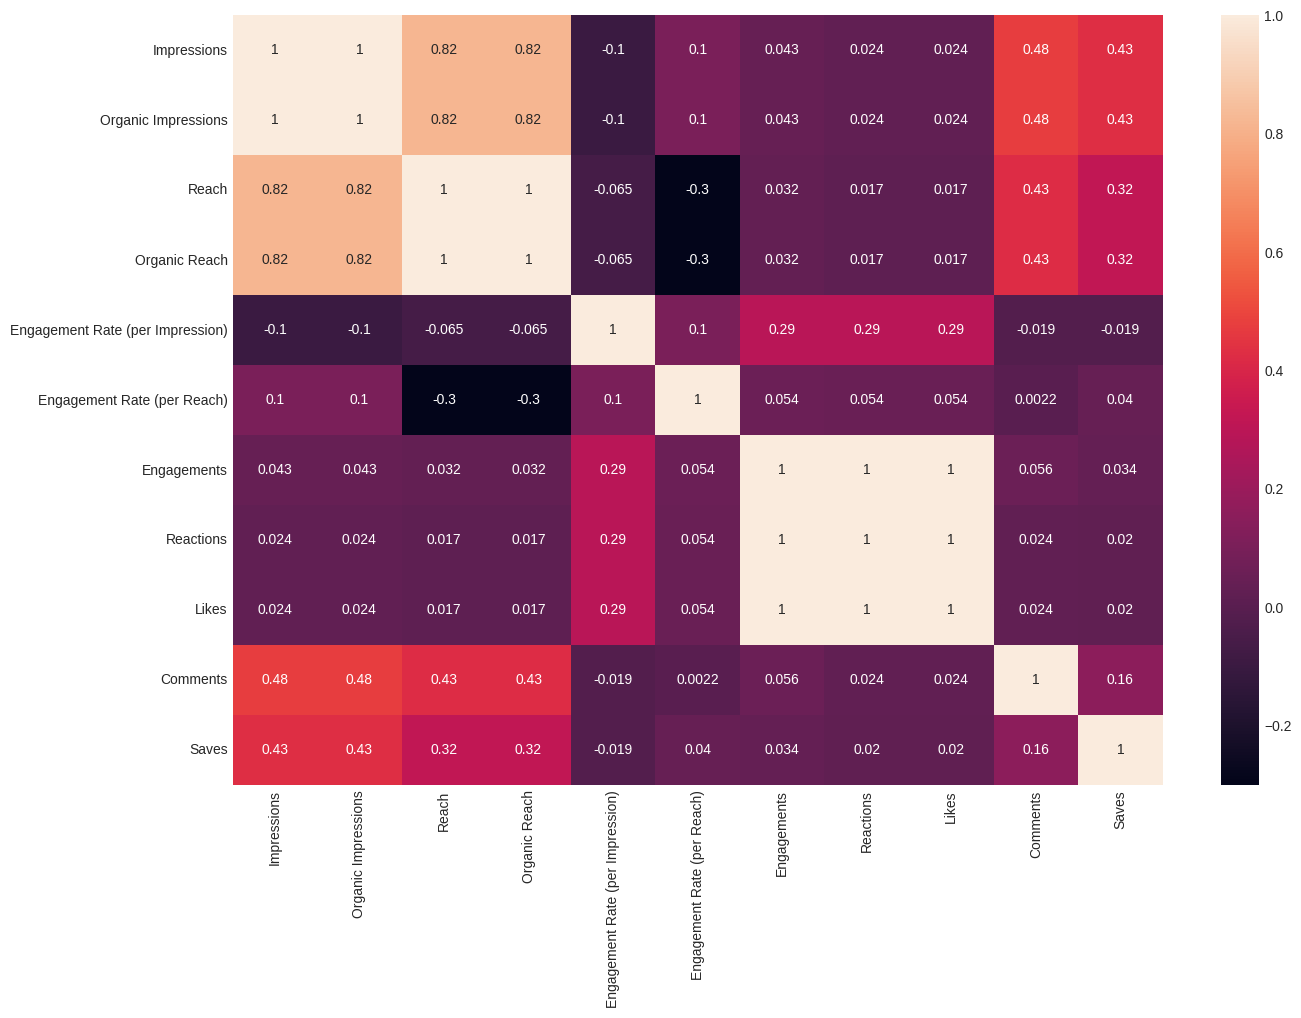

In [68]:
corr_matrix = cleaned_impressions_reach[high_cardinality_columns[3:]+num_cols]
heatmap(corr_matrix, length=15, width=10)

In [69]:
time_series_analysis(cleaned_impressions_reach,
                     num_cols,
                     duration='Y', fill=False)

In [70]:
time_series_analysis(cleaned_impressions_reach,
                     num_cols,
                     duration='M', fill=True)

In [71]:
time_series_analysis(cleaned_impressions_reach,
                     num_cols,
                     duration='7D', fill=True)

### Posts

In [72]:
data = cleaned_impressions_reach.copy()
data[['Post']].head(5)

,Post
0,The new Naira banknotes in circulation have se...
1,We hope the faith that this #GoodFriday restor...
2,Reposted from @mzdosunmu My son's entry\n#ITCA...
3,The new Naira banknotes in circulation have se...
4,"If you were born in June, ‘cut soap for us oh’..."


#### Preprocessing

In [73]:
remove_url=lambda x:re.sub(r'http\S+','',str(x))
to_lower=lambda x: x.lower()
remove_puncs= lambda x:x.translate(str.maketrans('','',string.punctuation))

more_words=["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him",
            "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves",
            "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being",
            "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as",
            "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before",
            "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then",
            "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some",
            "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don",
            "should", "now"]

stop_words=set(stopwords.words('english')) #nltk package
stop_words.update(more_words)

remove_words=lambda x: ' '.join([word for word in x.split() if word not in stop_words]) #.join is from package string

def preprocess_text(texts):
  texts = texts.apply(remove_url)
  texts = texts.apply(to_lower)
  texts = texts.apply(remove_puncs)
  texts = texts.apply(remove_words)
  return texts

def clean_text(text):
    '''remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# function to remove emoticons, symbols or flags by their codes
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


In [74]:
cleaned_posts = preprocess_text(data['Post'])
cleaned_posts = cleaned_posts.apply(lambda x: clean_text(x))
cleaned_posts = cleaned_posts.apply(lambda x: remove_emoji(x))

In [75]:
filtered_data = data.copy()
filtered_data['Post'] = cleaned_posts

,word,frq
0,itcanbe,4042
1,get,1853
2,stanbic,1680
3,ibtc,1674
4,visit,1494


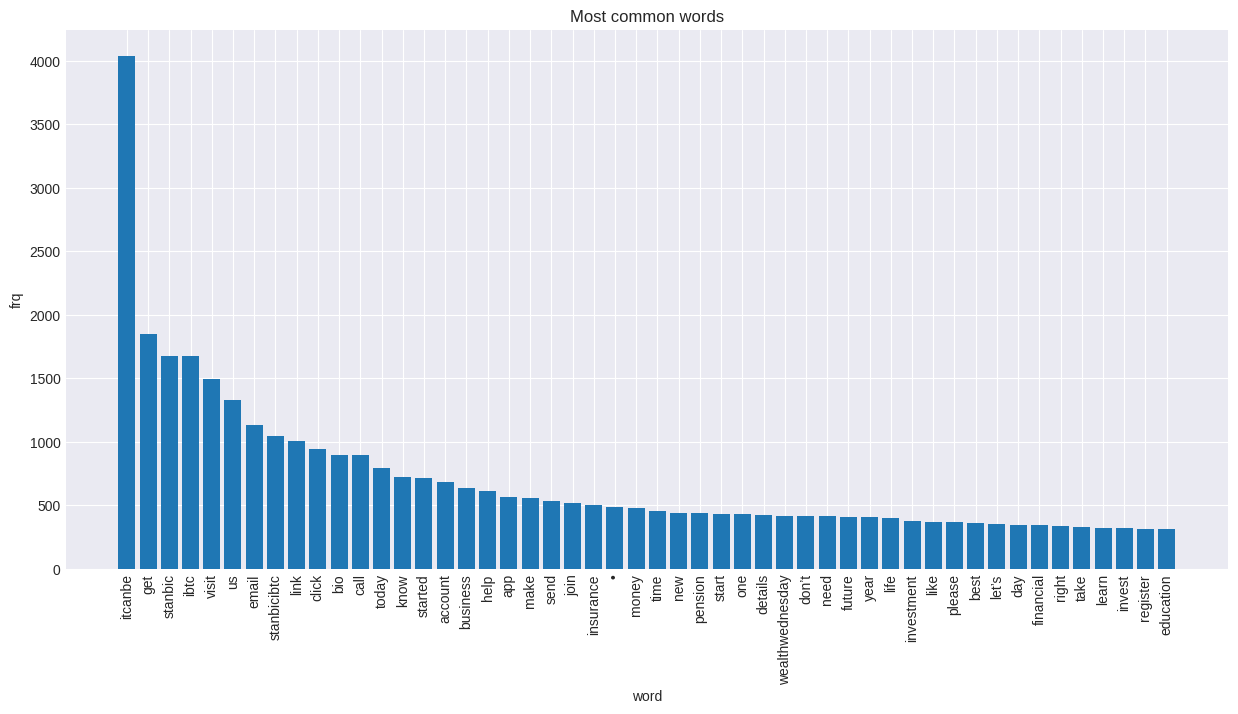

In [76]:
words_list=[word for line in cleaned_posts for word in line.split()]

# creating dataframe and bar graph of most common 50 words with their frequency
word_counts=Counter(words_list).most_common(50)
word_df=pd.DataFrame(word_counts)
word_df.columns=['word','frq']
display(word_df.head(5))

fig = plt.figure(figsize = (15, 7))

# creating the bar plot
plt.bar(word_df['word'],word_df['frq'])
plt.xticks(rotation=90)
plt.xlabel('word')
plt.ylabel('frq')
plt.title('Most common words')
plt.show()

In [77]:
from wordcloud import WordCloud

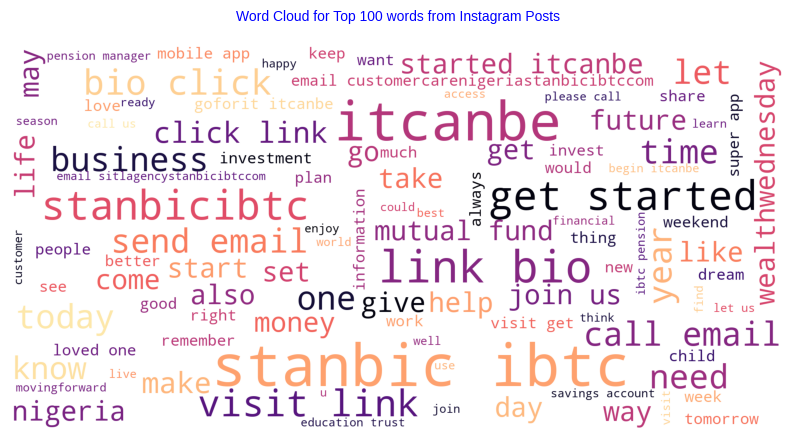

In [78]:
cut_text = " ".join(filtered_data['Post'])
max_words=100
word_cloud = WordCloud(
                    background_color='white',
                    stopwords=set(stop_words),
                    max_words=max_words,
                    max_font_size=30,
                    scale=5,
                    colormap='magma',
                    random_state=1).generate(cut_text)
fig = plt.figure(1, figsize=(10,10))
plt.axis('off')
plt.title('Word Cloud for Top '+str(max_words)+' words from Instagram Posts\n', fontsize=10,color='blue')
fig.subplots_adjust(top=2.3)
plt.imshow(word_cloud)
plt.show()

#### Annotation/Sentiment Analysis

In [79]:
sid=SentimentIntensityAnalyzer()
ps=lambda x:sid.polarity_scores(x)
sentiment_scores=filtered_data['Post'].apply(ps)

In [80]:
# create the data frame of negative, neutral, positive and compound polarity scores
sentiment_df=pd.DataFrame(data=list(sentiment_scores))
labelize=lambda x:'neutral' if x==0 else('positive' if x>0 else 'negative')
sentiment_df['sentiment_label']=sentiment_df.compound.apply(labelize)

filtered_data = filtered_data.join(sentiment_df['sentiment_label'])

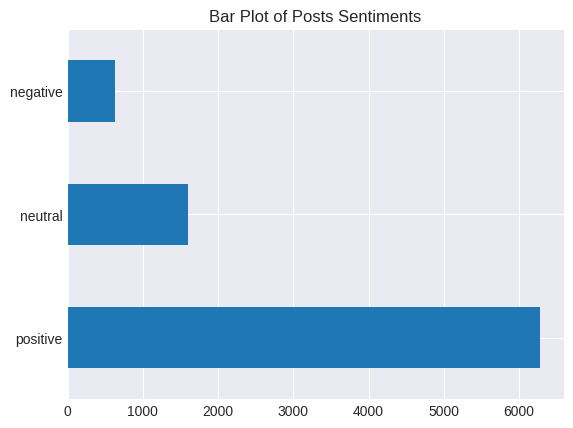

In [81]:
filtered_data['sentiment_label'].value_counts().plot(kind='barh',title="Bar Plot of Posts Sentiments");

In [82]:
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

# spaCy based imports
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
!python -m spacy download en_core_web_lg

2023-10-08 16:19:34.023708: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [83]:
def topic_modelling(text, n=10):

  cvectorizer = CountVectorizer(max_df=0.95, min_df=2,stop_words='english',decode_error='ignore')
  lda_model = LatentDirichletAllocation(n_components=8,learning_method='online',max_iter=20,random_state=42)
  cvz = cvectorizer.fit_transform(text)
  X_topics = lda_model.fit_transform(cvz)
  n_top_words = n
  topic_summaries = []

  topic_word = lda_model.components_  # get the topic words
  vocab = cvectorizer.get_feature_names_out()

  for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
    print('Topic {}: {}'.format(i, ' | '.join(topic_words)))

  return cvectorizer, lda_model, topic_summaries

In [84]:
## Get LDA Topics

vectorizer, lda_model, topic_summaries = topic_modelling(filtered_data['Post'], n=15)

Topic 0: stanbicibtc | itcanbe | future | plan | time | school | child | set | weekend | money | loved | save | ones | goals | year
Topic 1: itcanbe | link | visit | click | bio | business | join | pension | stanbic | ibtc | register | live | know | watch | health
Topic 2: stanbic | ibtc | nigeria | growth | itcanbe | bank | africa | partner | tips | business | financial | lagos | capital | nigerian | giving
Topic 3: stanbicibtc | day | win | hiflstanbicibtc | itcanbe | repost | steps | winners | forward | stay | code | follow | service | team | investments
Topic 4: insurance | itcanbe | life | year | education | movingforward | today | best | happy | trust | better | wealthwednesday | neverstop | like | walk
Topic 5: email | details | information | account | itcanbe | customercarenigeriastanbicibtccom | send | got | think | stay | happentolife | credit | ve | safe | pensionsolutionstanbicibtccom
Topic 6: itcanbe | email | let | started | know | visit | help | invest | investment | sen

Based on the topics you've provided, here are 8 unique categories that could be created:

1. **Future Planning & Financial Goals**: This category could include posts about planning for the future, setting goals, saving money, and preparing for things like school or retirement (Topic 0).
2. **Business & Pension**: This category could cover posts related to business, pension plans, and financial growth (Topic 1).
3. **Banking & Financial Partnerships**: This category could include posts about banking services, financial partnerships, and economic growth in Africa (Topic 2).
4. **Competitions & Team Spirit**: This category could cover posts about competitions, winning teams, and team spirit (Topic 3).
5. **Insurance & Life Planning**: This category could include posts about insurance plans, life planning, and wealth management (Topic 4).
6. **Customer Service & Account Management**: This category could cover posts about account management, customer service, and safety measures (Topic 5).
7. **Investments & Financial Advice**: This category could include posts offering financial advice, investment tips, and ways to grow your money (Topic 6).
8. **Digital Banking & Mobile Services**: This category could cover posts about digital banking services, mobile banking apps, and the convenience of banking on the go (Topic 7).

In [85]:
topic_labels = ['Future Planning & Financial Goals','Business & Pension','Banking & Financial Partnerships','Competitions & Team Spirit',
                'Insurance & Life Planning','Customer Service & Account Management','Investments & Financial Advice',
                'Digital Banking & Mobile Services']

def assign_topic_to_text(text, cvectorizer, lda_model, topic_labels):
    transformed_text = cvectorizer.transform([text])
    topic_distribution = lda_model.transform(transformed_text)
    best_topic = np.argmax(topic_distribution[0])

    return topic_labels[best_topic]

filtered_data['topic_label'] = filtered_data['Post'].apply(
    lambda x: assign_topic_to_text(x, vectorizer, lda_model, topic_labels))

In [86]:
nlp = spacy.load('en_core_web_lg')

In [87]:
def named_entity_recognition(text):
  doc = nlp(text)
  label = [(X.label_) for X in doc.ents]
  return label

def part_of_speech_tagging(text):
  doc = nlp(text)
  label = [(X.pos_) for X in doc]
  return label

filtered_data['ner_label'] = filtered_data['Post'].apply(lambda x:named_entity_recognition(x))
filtered_data['pos_label'] = filtered_data['Post'].apply(lambda x:part_of_speech_tagging(x))

In [88]:
filtered_data['ner_count'] = filtered_data['ner_label'].apply(lambda x:len(x))
filtered_data['pos_count'] = filtered_data['pos_label'].apply(lambda x:len(x))

In [89]:
ner_tags = ['CARDINAL','DATE','GPE','LOC','MONEY','ORDINAL','ORG','PERSON','TIME']
for tag in ner_tags:
  filtered_data[tag + '_count'] = filtered_data['ner_label'].apply(lambda x: x.count(tag))

In [90]:
pos_tags = ['VERB', 'ADV', 'ADJ', 'NUM', 'NOUN', 'SPACE', 'PROPN']
for tag in pos_tags:
    filtered_data[tag + '_count'] = filtered_data['pos_label'].apply(lambda x: x.count(tag))

### Let's Delve in for Deeper Analysis

Let's see the distribution of words for each year

In [91]:
def get_top_n_words(cleaned_posts, ax, n:int=20):
    words_list=[word for line in cleaned_posts for word in line.split()]
    word_counts=Counter(words_list).most_common(n)
    word_df=pd.DataFrame(word_counts)
    word_df.columns=['word','frq']

    ax.bar(word_df['word'],word_df['frq'])
    ax.set_xticklabels(word_df['word'], rotation=90)
    ax.set_xlabel('word')
    ax.set_ylabel('frq')

def word_cloud(texts, ax, n:int=100):
    cut_text = " ".join(texts)
    max_words=n
    word_cloud = WordCloud(
                      background_color='white',
                      stopwords=set(stop_words),
                      max_words=max_words,
                      max_font_size=30,
                      scale=1,
                      colormap='magma',
                      random_state=42).generate(cut_text)
    ax.axis('off')
    ax.imshow(word_cloud)

def sentiment_analyzer(text, ax):
    sid=SentimentIntensityAnalyzer()
    ps=lambda x:sid.polarity_scores(x)
    sentiment_scores=text.apply(ps)

    sentiment_df=pd.DataFrame(data=list(sentiment_scores))
    labelize=lambda x:'neutral' if x==0 else('positive' if x>0 else 'negative')
    sentiment_df['label']=sentiment_df.compound.apply(labelize)

    sentiment_df['label'].value_counts().plot(kind='barh', ax=ax);

In [92]:
def visualize_data(df, column, column_value):
    df_year = df[df[column] == column_value]

    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    get_top_n_words(df_year['Post'].values, axs[0, 0], n=10)
    axs[0, 0].set_title(f"Top 10 Words in the Top 1% Impression {column_value}")

    word_cloud(df_year['Post'].values, axs[0, 1], n=50)
    axs[0, 1].set_title(f"Word Cloud for Top 50 words in the Top 1% Impression {column_value} period")

    labels = sentiment_analyzer(df_year['Post'], axs[1, 1])
    axs[1, 1].set_title(f"Sentiment Analyzer of Tweets in the Top 1% Impression {column_value} period")

    plt.tight_layout()
    plt.show()


# def plot_pos_labels(df, column, pos_tags, rows=2, cols=3, plot=False):

#     pos_cols = [f"{pos}_count" for pos in pos_tags]

#     if plot == False:

#       display(df.groupby(column)[pos_cols+['pos_count']].sum().sort_values(by=['pos_count'],ascending=False))

#     else:
#       df_grouped = df.groupby(column)[pos_cols].sum()

#       fig, axs = plt.subplots(rows, cols, figsize=(15, 10))
#       fig.patch.set_facecolor('black')

#       axs = axs.flatten()

#       for ax, (year, row) in zip(axs, df_grouped.iterrows()):
#           ax.pie(row, labels=row.index, autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'], textprops={'color':'#ffffff'})
#           ax.set_title(f'POS Tag Distribution in {year}', color='white')

#       plt.tight_layout()
#       plt.show()

# def plot_ner_labels(df, column, ner_tags, rows=2, cols=3, plot=False):

#     ner_cols = [f"{ner}_count" for ner in ner_tags]

#     if plot == False:

#       display(df.groupby(column)[ner_cols+['ner_count']].sum().sort_values(by=['ner_count'],ascending=False))

#     else:
#       df_grouped = df.groupby(column)[ner_cols].sum()

#       fig, axs = plt.subplots(rows, cols, figsize=(15, 10))
#       fig.patch.set_facecolor('black')

#       axs = axs.flatten()

#       for ax, (year, row) in zip(axs, df_grouped.iterrows()):
#           ax.pie(row, labels=row.index, autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'], textprops={'color':'#ffffff'})
#           ax.set_title(f'NER Tag Distribution in {year}', color='white')

#       plt.tight_layout()
#       plt.show()

In [129]:
def plot_pos_labels(df, column, pos_tags, rows=2, cols=3, height=750, width=1000, plot=False):
    pos_cols = [f"{pos}_count" for pos in pos_tags]

    if plot == False:
        display(df.groupby(column)[pos_cols+['pos_count']].sum().sort_values(by=['pos_count'],ascending=False))
    else:
        df_grouped = df.groupby(column)[pos_cols].sum()
        specs = [[{'type':'domain'} for _ in range(cols)] for _ in range(rows)]
        axs = [i for i in range(rows * cols)]
        titles = [str(title) for title in df_grouped.index[:len(axs)]]
        fig = make_subplots(rows=rows, cols=cols, subplot_titles=titles, specs=specs)

        for ax, (year, vrow) in zip(axs, df_grouped.iterrows()):
            nrow = ax // cols + 1
            ncol = ax % cols + 1

            fig.add_trace(
                go.Pie(labels=pos_tags, values=vrow.values, name=year),
                row=nrow, col=ncol
            )

        fig.update_layout(height=height, width=width,
                          title_text='POS Tag Distribution',
                          paper_bgcolor='skyblue',
                          plot_bgcolor='skyblue'
                          )

        fig.show()

def plot_ner_labels(df, column, ner_tags, rows=2, cols=3, height=750, width=1000, plot=False):
    ner_cols = [f"{ner}_count" for ner in ner_tags]

    if plot == False:
        display(df.groupby(column)[ner_cols+['ner_count']].sum().sort_values(by=['ner_count'],ascending=False))
    else:
        df_grouped = df.groupby(column)[ner_cols].sum()
        specs = [[{'type':'domain'} for _ in range(cols)] for _ in range(rows)]
        axs = [i for i in range(rows * cols)]
        titles = [str(title) for title in df_grouped.index[:len(axs)]]
        fig = make_subplots(rows=rows, cols=cols, subplot_titles=titles, specs=specs)

        for ax, (year, vrow) in zip(axs, df_grouped.iterrows()):
            nrow = ax // cols + 1
            ncol = ax % cols + 1

            fig.add_trace(
                go.Pie(labels=pos_tags, values=vrow.values, name=year),
                row=nrow, col=ncol
            )

        fig.update_layout(height=height, width=width,
                          title_text='NER Tag Distribution',
                          paper_bgcolor='skyblue',
                          plot_bgcolor='skyblue'
                          )

        fig.show()


In [94]:
# def visualize_labels(df, column, column_values, colors, rows=1, cols=3, length=15, width=10):

#   fig, axs = plt.subplots(rows, cols, figsize=(length, width))
#   axs = axs.ravel()

#   for i, value in enumerate(column_values):

#     df[df[column]==value]['topic_label'].value_counts().plot(kind='barh', color=colors[i], ax=axs[i])
#     axs[i].set_title(f'{value} Topic Labels')

#   plt.tight_layout()
#   plt.show()


In [95]:
def visualize_labels(df, column, column_values, colors, rows=1, cols=3, height=800, width=1200):

  fig = make_subplots(rows, cols, subplot_titles=column_values)

  for i, value in enumerate(column_values):
    nrows = i // cols + 1
    ncols = i % cols + 1

    df_vc = df[df[column]==value]['topic_label'].value_counts()
    fig.add_trace(go.Bar(
        x=df_vc.values, y=df_vc.index, orientation='h', marker_color=colors[i], name=value,
        ),
        row=nrows, col=ncols)
    fig.update_yaxes(showgrid=True,showticklabels=False)

  fig.update_layout(height=height, width=width,legend_title=column,
                    title_text="Distribution Topic Labels",
                    showlegend=False
                    )
  fig.show()


In [96]:
# def barplot_labels(data, plotted_cols, colors, rows=2, cols=4, length=25, width=20):

#   fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(length, width))
#   axs = axs.ravel()

#   for i, column in enumerate(plotted_cols):
#     df_yearly = data.groupby(['topic_label'])[column].mean()
#     df_yearly = df_yearly.sort_values(ascending=True)
#     axs[i].barh(df_yearly.index, df_yearly.values, color=colors[i])  # Use color corresponding to column

#     axs[i].set_xlabel(column)
#     axs[i].set_ylabel('Topic Label')
#     axs[i].set_title(f'Distribution of Instagram {column} across Topic Labels', fontsize=10)

#   plt.tight_layout()
#   plt.show()

In [97]:
def barplot_labels(data, plotted_cols, colors, rows=2, cols=4, height=800, width=1200):

  subplot_titles = [f'Distribution of Instagram {col} across Topic Labels' for col in plotted_cols]
  fig = make_subplots(rows, cols, subplot_titles=subplot_titles)

  for i, column in enumerate(plotted_cols):
    nrows = i // cols + 1
    ncols = i % cols + 1

    df_yearly = data.groupby(['topic_label'])[column].mean()
    df_yearly = df_yearly.sort_values(ascending=True)
    fig.add_trace(go.Bar(
        x=df_yearly.values, y=df_yearly.index, orientation='h', marker_color=colors[i], name=column,
        ),
        row=nrows, col=ncols)
    fig.update_yaxes(title_text="Topic Label", showgrid=True,showticklabels=False, row=nrows,col=ncols)
    fig.update_xaxes(title_text=column, row=nrows,col=ncols)

  fig.update_layout(height=height, width=width,
                    title_text="Distribution of Instagram Topic Labels",
                    )
  fig.show()

In [98]:
# def stack_barchart(data, plot_col, length=15, width=10):

#   df = data.groupby([plot_col, 'topic_label'])[['topic_label']].count().rename(columns={'topic_label':'topic_count'})
#   df = df.reset_index()

#   pivot_df = df.pivot(index='topic_label', columns=plot_col, values='topic_count').fillna(0)

#   # Plotting
#   plt.figure(figsize=(10,7))
#   pivot_df.plot(kind='bar', stacked=True, figsize=(10,7))

#   plt.xlabel('Topic Label')
#   plt.ylabel('Frequency')
#   plt.title(f'Distribution of Topic Labels Across Each {plot_col}')
#   plt.legend(title=plot_col)

#   plt.show()


In [99]:
def stack_barchart(data, plot_col, length=15, width=10):

  df = data.groupby([plot_col, 'topic_label'])[['topic_label']].count().rename(columns={'topic_label':'topic_count'})
  df = df.reset_index()

  pivot_df = df.pivot(index='topic_label', columns=plot_col, values='topic_count').fillna(0)

  # Assuming pivot_df is your DataFrame
  fig = go.Figure(data=[
      go.Bar(name=year, x=pivot_df.index, y=pivot_df[year]) for year in pivot_df.columns
  ])
  fig.update_xaxes(title_text='Topic Label')
  fig.update_yaxes(title_text='Frequency')
  # Change the bar mode
  fig.update_layout(barmode='stack', title_text=f'Distribution of Topic Labels Across Each {plot_col}')

  fig.show()


In [100]:
colors = ['skyblue', 'olive', 'gold', 'purple', 'red', 'green', 'orange', 'brown']

#### Distribution of Whole Dataset

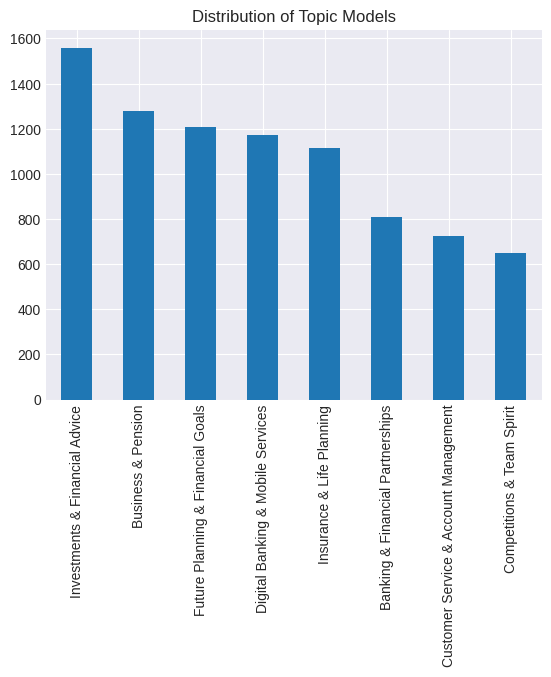

In [101]:
filtered_data['topic_label'].value_counts().plot(kind='bar',title="Distribution of Topic Models");

In [102]:
pos_cols = [f"{pos}_count" for pos in pos_tags]
ner_cols = [f"{ner}_count" for ner in ner_tags]

filtered_data.groupby(['topic_label'])[pos_cols+['pos_count']].mean().sort_values(by=['pos_count'],ascending=False)

,VERB_count,ADV_count,ADJ_count,NUM_count,NOUN_count,SPACE_count,PROPN_count,pos_count
topic_label,,,,,,,,
Banking & Financial Partnerships,3.284653,0.397277,2.297030,0.089109,7.440594,0.766089,6.094059,21.342822
Business & Pension,4.151562,0.333594,1.870313,0.089844,7.459375,0.851562,3.172656,19.389063
Future Planning & Financial Goals,4.051325,0.673013,2.154801,0.091060,6.682947,0.655629,2.664735,18.902318
Investments & Financial Advice,4.457051,0.500000,1.852564,0.082692,6.760897,0.611538,1.925000,18.027564
Digital Banking & Mobile Services,3.291809,0.316553,2.178328,0.109215,6.674061,0.977816,2.326792,17.077645
Insurance & Life Planning,3.780969,0.524237,1.792639,0.087971,6.188510,0.657989,2.239677,17.054758
Competitions & Team Spirit,2.989198,0.439815,1.643519,0.070988,6.007716,1.054012,3.432099,16.865741
Customer Service & Account Management,3.264463,0.483471,1.392562,0.114325,6.249311,0.774105,1.957300,15.691460


In [132]:
filtered_data.groupby(['topic_label'])[ner_cols+['ner_count']].mean().sort_values(by=['ner_count'],ascending=False)

,CARDINAL_count,DATE_count,GPE_count,LOC_count,MONEY_count,ORDINAL_count,ORG_count,PERSON_count,TIME_count,ner_count
topic_label,,,,,,,,,,
Banking & Financial Partnerships,0.061881,0.324257,0.396040,0.032178,0.006188,0.035891,0.763614,0.551980,0.024752,2.373762
Competitions & Team Spirit,0.078704,0.283951,0.126543,0.004630,0.003086,0.055556,0.516975,0.476852,0.026235,1.635802
Business & Pension,0.057813,0.396094,0.207813,0.005469,0.007031,0.020313,0.601562,0.228906,0.032031,1.621875
Future Planning & Financial Goals,0.064570,0.461921,0.107616,0.000828,0.001656,0.028974,0.432947,0.464404,0.022351,1.620033
Investments & Financial Advice,0.055128,0.309615,0.192949,0.001282,0.009615,0.019231,0.594872,0.192949,0.005769,1.414744
Digital Banking & Mobile Services,0.069113,0.373720,0.151877,0.000000,0.021331,0.020478,0.474403,0.160410,0.019625,1.329352
Insurance & Life Planning,0.057451,0.393178,0.157989,0.005386,0.000000,0.038600,0.359066,0.250449,0.012567,1.315978
Customer Service & Account Management,0.110193,0.136364,0.082645,0.001377,0.000000,0.026171,0.469697,0.391185,0.004132,1.253444


In [ ]:
barplot_labels(filtered_data, impression_cols, colors,rows=1,cols=2)

In [ ]:
barplot_labels(filtered_data, reach_cols, colors,rows=1,cols=2)

In [ ]:
barplot_labels(filtered_data, engagement_cols, colors,rows=2,cols=2)

In [ ]:
barplot_labels(filtered_data, rlc_cols+num_cols, colors,rows=2,cols=2)

In [ ]:
stack_barchart(filtered_data, "year")

In [ ]:
stack_barchart(filtered_data, "time_period")

In [ ]:
stack_barchart(filtered_data, "day_name")

In [ ]:
stack_barchart(filtered_data, "day_period")

In [ ]:
stack_barchart(filtered_data, "quarter")

In [ ]:
wrt = filtered_data[filtered_data['holiday_types']!='Regular Type']
stack_barchart(wrt, "holiday_types")

#### Top 1% Impressions


In [191]:
last_quantile = filtered_data['Impressions'].quantile(0.99) #Posts that had Impression in the Top 1%
df = filtered_data[cleaned_impressions_reach['Impressions'] > last_quantile]


In [ ]:
visualize_data(df, "year", 2021)

In [ ]:
visualize_data(df, "year", 2022)

In [ ]:
visualize_labels(df, "year", [2021, 2022], colors, rows=1, cols=2,)

In [149]:
plot_pos_labels(df, "year",  pos_tags, plot=True)

In [150]:
plot_ner_labels(df, "year",  ner_tags, plot=True)

In [ ]:
visualize_data(df, "time_period", "Morning")

In [ ]:
visualize_data(df, "time_period", "Afternoon")

In [ ]:
visualize_data(df, "time_period", "Evening")

In [ ]:
visualize_labels(df, "time_period", ["Morning", "Afternoon", "Evening"], colors, rows=2, cols=2)

In [152]:
plot_pos_labels(df, "time_period", pos_tags, rows=2, cols=2, plot=True)

In [153]:
plot_ner_labels(df, "time_period", ner_tags, plot=True)

In [ ]:
visualize_labels(df, "day_name", ["Saturday", "Sunday", "Friday"], colors, rows=2, cols=2)


In [155]:
plot_pos_labels(df, "day_name", pos_tags, rows=3, cols=3, plot=True)

In [156]:
plot_pos_labels(df, "day_name", ner_tags, rows=3, cols=3, plot=True)

In [199]:
visualize_labels(df, "quarter", ["Q2", "Q4"], colors, rows=1, cols=2)

In [158]:
plot_pos_labels(df, "quarter", pos_tags, rows=2, cols=2, plot=True)

In [159]:
plot_ner_labels(df, "quarter", ner_tags, rows=2, cols=2, plot=True)

#### Top 1% Engagements

In [205]:
last_quantile = filtered_data['Engagements'].quantile(0.99) #Posts that had Engagements in the Top 1%
df = filtered_data[cleaned_impressions_reach['Engagements'] > last_quantile]


In [ ]:
visualize_labels(df, "year", [2022, 2021, 2023], colors, rows=2, cols=2)



In [162]:
plot_pos_labels(df, "year",  pos_tags, plot=True)

In [163]:
plot_ner_labels(df, "year",  ner_tags, plot=True)

In [206]:
visualize_labels(df, "time_period", ["Morning", "Afternoon", "Evening"], colors, rows=2, cols=2)

In [167]:
plot_pos_labels(df, "time_period",  ner_tags, plot=True)

In [168]:
plot_ner_labels(df, "time_period",  ner_tags, plot=True)

In [208]:
visualize_labels(df, "day_name", ["Friday", "Saturday", "Thursday"], colors, rows=2, cols=2)

In [170]:
plot_pos_labels(df, "day_name", pos_tags, rows=3, cols=3, plot=True)

In [171]:
plot_ner_labels(df, "day_name", ner_tags, rows=3, cols=3, plot=True)

In [210]:
visualize_labels(df, "quarter", ["Q2", "Q4"], colors, rows=1, cols=2)


In [173]:
plot_pos_labels(df, "quarter", pos_tags, rows=2, cols=2, plot=True)

In [174]:
plot_ner_labels(df, "quarter", ner_tags, rows=2, cols=2, plot=True)